Use data science 3 image

# Installs

In [ ]:
!pip install torch tenseal numpy scikit-learn torchvision torchmetrics imblearn matplotlib tqdm seaborn "pandas<=2.0.0"

In [4]:
!pip freeze | xargs pip uninstall -y

ERROR: Invalid requirement: '@'


In [5]:
import sys
print(sys.version)

3.10.6 (main, Oct  7 2022, 20:19:58) [GCC 11.2.0]


# Imports

In [3]:
import torch
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, AUROC
from torch.utils.data import Dataset
import tenseal as ts
import pandas as pd
import random
from time import time
import pickle
import json
import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
import seaborn as sns

import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import tqdm as tqdm

import random

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Set2')

## 

# Variables

In [4]:
seed = 15
#n_features = 60
n_features = 20
threshold = 0.5
learning_rate = 1e-1
momentum = 0.9
train_data_path = "./embeddings_sent_train_sstb_pca_20.pkl"
test_data_path = "./embeddings_sent_test_sstb_pca_20.pkl"

In [5]:
# learning rate
print(format(learning_rate, 'f'))

0.100000


# Helpers

In [5]:
def set_seed(seed=seed):
    torch.manual_seed(seed)
    random.seed(seed)

In [9]:
with open(train_data_path, "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_labels = stored_data['labels']
    stored_embeddings = stored_data['embeddings']
    # convert into a dataframe
df = pd.DataFrame(pd.DataFrame(data = stored_embeddings))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,14.052566,-23.923035,-6.556353,-3.861839,-0.521402,2.790199,4.182197,-5.588435,0.182398,-2.729989,-5.241620,0.209205,-0.394859,-2.941516,0.385759,-0.677056,1.694376,-1.230819,1.490928,-2.028240
1,19.854282,0.497542,4.183672,10.819630,1.708729,2.526631,2.484919,-3.430412,0.817815,2.178958,-13.918652,-2.819229,-4.140326,2.395941,-1.314899,2.705606,-0.304852,-4.574224,2.070322,-2.748550
2,17.186382,-23.175190,-6.384917,-1.512172,-4.157166,-1.042760,-1.167418,2.208377,1.299185,-0.480950,-1.372745,-0.131752,-2.895539,-1.700357,-1.808056,1.374368,0.046249,-1.100810,-1.562679,1.266307
3,26.005203,21.063097,1.138029,0.532839,0.425382,-1.447903,-7.463132,-0.322506,-0.197895,4.782021,-1.181313,3.083845,-0.715277,-1.986995,0.629198,2.502158,-1.537187,-3.216022,-2.557100,-1.586898
4,23.649910,-2.761907,2.687742,8.025290,-5.350758,-1.527654,-0.635113,-4.391125,-3.094957,-1.521332,-3.295672,0.432543,-1.401680,4.816146,-3.094819,-3.269163,-0.365448,-1.877755,-0.462947,-0.622680


In [10]:
X_train = df.iloc[:,0:20].values
len(X_train)

7792

In [13]:
df['label'] = stored_labels.tolist()
y_train = df.label.values 
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
smote = SMOTE(random_state=15)
X_train , y_train = smote.fit_resample(X_train, y_train)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f100a513f40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [15]:
print('y dist', Counter(y_train))

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(-1)

print('y train shape', y_train.shape, y_train.dtype)
print('x train shape', X_train.shape, X_train.dtype)

y dist Counter({0: 4054, 1: 4054})
y train shape torch.Size([8108, 1]) torch.float32
x train shape torch.Size([8108, 20]) torch.float32


In [17]:
with open(test_data_path, "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_labels = stored_data['labels']
    stored_embeddings = stored_data['embeddings']
    # convert into a dataframe
df = pd.DataFrame(pd.DataFrame(data = stored_embeddings))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,24.838589,2.772899,6.192329,-5.711214,-5.921356,-5.579364,2.758016,-2.517978,-1.700168,-2.665378,...,0.458046,-0.114620,0.467117,0.807749,0.441265,-0.132648,-0.183448,-0.270605,-0.654404,-0.965474
1,9.275372,-20.016434,-2.671589,1.874329,1.743079,1.100554,-0.448698,1.223266,-0.318874,1.556196,...,-1.182605,-0.009859,0.394505,-0.133958,-0.549358,-0.710158,0.087089,-1.721997,0.004093,0.714983
2,24.425743,1.974569,-4.349919,5.802249,-4.657108,-5.172925,2.169193,-5.134622,-0.304869,1.786149,...,-0.633044,-1.731556,0.183292,-0.300125,-0.774867,2.258275,0.713953,-0.237055,-2.807298,0.852026
3,-19.166903,0.096890,2.470870,2.112333,3.888633,0.672453,1.589819,-0.168794,-3.190851,-3.883037,...,-0.788513,-0.538511,-0.304908,0.132751,0.141823,-0.484662,0.329189,0.349774,-0.663601,-0.662485
4,-22.814823,7.818967,0.386258,0.562299,-4.302380,1.176964,1.176679,1.893128,-0.159800,0.138781,...,0.440979,-0.007396,-0.369705,-0.191070,0.166546,0.148282,-0.098242,-0.101657,0.033199,0.307078


In [18]:
X_test = df.iloc[:,0:20].values
len(X_test)

1821

In [19]:
df['label'] = stored_labels.tolist()
y_test = df.label.values 
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [20]:
print('y dist', Counter(y_test))

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(-1)

print('y test shape', y_test.shape, y_test.dtype)
print('x test shape', X_test.shape, X_test.dtype)

y dist Counter({1: 912, 0: 909})
y test shape torch.Size([1821, 1]) torch.float32
x test shape torch.Size([1821, 60]) torch.float32


## Data loader

In [6]:
def mydata(embedding_fp,  num_samples, seed=15, n_features=n_features, balance=False):
    # read the file
    with open(embedding_fp, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_labels = stored_data['labels']
        stored_embeddings = stored_data['embeddings']
    # convert into a dataframe
    df = pd.DataFrame(pd.DataFrame(data = stored_embeddings))
    print('Data frame length', len(df))
    df['label'] = stored_labels.tolist()
    
    # select a subset of features
    X = df.iloc[:,0:n_features].values
    y = df.label.values  


    if balance:
        rus = RandomUnderSampler(random_state=seed, replacement=True)
        X, y = rus.fit_resample(X, y)
        
#        smote = SMOTE(random_state=15)
#        X,y = smote.fit_resample(X, y)
    
    if num_samples is not None:
        # resample data
        df = df.sample(num_samples, random_state=seed)
    
    print('y dist', Counter(y))
    
    X = torch.FloatTensor(X)
    y = torch.FloatTensor(y).unsqueeze(-1)
    
    print('y shape', y.shape, y.dtype)
    print('x shape', X.shape, X.dtype)
    
    return X, y

# Load training data

In [15]:
train_data = mydata(train_data_path, num_samples = 7792, balance=True, n_features=20)
X_train, y_train = train_data

Data frame length 7792
y dist Counter({0: 3738, 1: 3738})
y shape torch.Size([7476, 1]) torch.float32
x shape torch.Size([7476, 20]) torch.float32


# Load test data

In [8]:
test_data = mydata(test_data_path, balance=False, num_samples=None, n_features=n_features)
X_test, y_test = test_data

Data frame length 1821
y dist Counter({1: 912, 0: 909})
y shape torch.Size([1821, 1]) torch.float32
x shape torch.Size([1821, 20]) torch.float32


## Training a Logistic Regression Model without encryption

## Model

In [11]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

## Metrics

In [12]:
acc_fn = BinaryAccuracy(threshold=threshold)
f1_fn = BinaryF1Score(threshold=threshold)
auroc_fn = AUROC(task="binary")
pre_fn = BinaryPrecision(threshold=threshold)
recall_fn = BinaryRecall(threshold=threshold)

## Train

In [13]:
def train(model, optim, criterion, x, y, x_test, y_test, epochs=150):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        train_loss_hist.append(loss.item())
        loss.backward()
        optim.step()
        acc = acc_fn(out, y)
        f1 = f1_fn(out, y)
        auroc = auroc_fn(out, y)
        pre = pre_fn(out,y)
#        print(f"Loss train data at epoch {e}: {loss.data}| Acc: {acc.data:.5f}% | Precision: {pre.data:.5f}% | F1-score: {f1.data:.5f}% | AUROC: {auroc.data:.5f}%")
               
        out_test = model(x_test)
        loss_test = criterion(out_test, y_test)
        test_loss_hist.append(loss_test.item())
        acc_ = acc_fn(out_test, y_test)
        f1_ = f1_fn(out_test, y_test)
        auroc_ = auroc_fn(out_test, y_test)
        pre_ = pre_fn(out_test, y_test)
        re_ = recall_fn(out_test, y_test)
        
        print(f"Loss test data at epoch {e}: {loss_test.data:.4f}| Acc: {acc_.data:.5f}% | Recall: {re_.data:.4f}% |Precision: {pre_.data:.4f}% | F1-score: {f1_.data:.4f}% | AUROC: {auroc_.data:.4f}%")
    
    return model

In [16]:
# 20 features
t_start = time()

set_seed()
test_loss_hist = []
train_loss_hist = []
epochs = 150
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

model = train(model, optim, criterion, X_train, y_train, X_test, y_test, epochs=epochs) # 150 epochs

t_end = time()
print(f"\nPlain model training took: {int(t_end - t_start)} seconds")

Loss test data at epoch 1: 0.8665| Acc: 0.82098% | Recall: 0.7741% |Precision: 0.8547% | F1-score: 0.8124% | AUROC: 0.8770%
Loss test data at epoch 2: 0.9385| Acc: 0.82427% | Recall: 0.7664% |Precision: 0.8672% | F1-score: 0.8137% | AUROC: 0.8947%
Loss test data at epoch 3: 0.4494| Acc: 0.86711% | Recall: 0.8596% |Precision: 0.8731% | F1-score: 0.8663% | AUROC: 0.9380%
Loss test data at epoch 4: 0.7849| Acc: 0.80066% | Recall: 0.9287% |Precision: 0.7397% | F1-score: 0.8235% | AUROC: 0.7826%
Loss test data at epoch 5: 0.5079| Acc: 0.83086% | Recall: 0.9035% |Precision: 0.7893% | F1-score: 0.8425% | AUROC: 0.9055%
Loss test data at epoch 6: 0.7693| Acc: 0.77100% | Recall: 0.7489% |Precision: 0.7842% | F1-score: 0.7661% | AUROC: 0.8781%
Loss test data at epoch 7: 0.7118| Acc: 0.84239% | Recall: 0.7796% |Precision: 0.8921% | F1-score: 0.8321% | AUROC: 0.9183%
Loss test data at epoch 8: 0.6130| Acc: 0.85557% | Recall: 0.8783% |Precision: 0.8405% | F1-score: 0.8590% | AUROC: 0.9359%
Loss tes

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


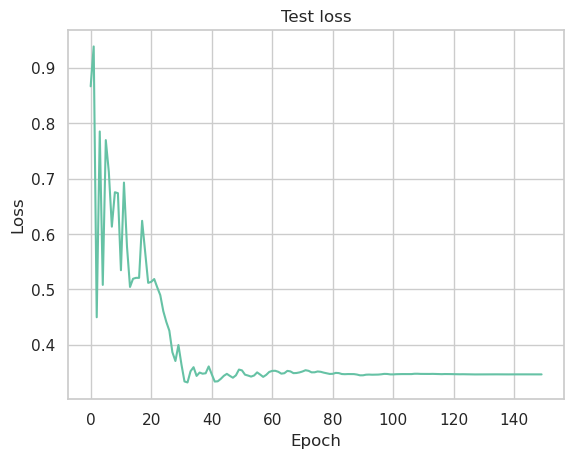

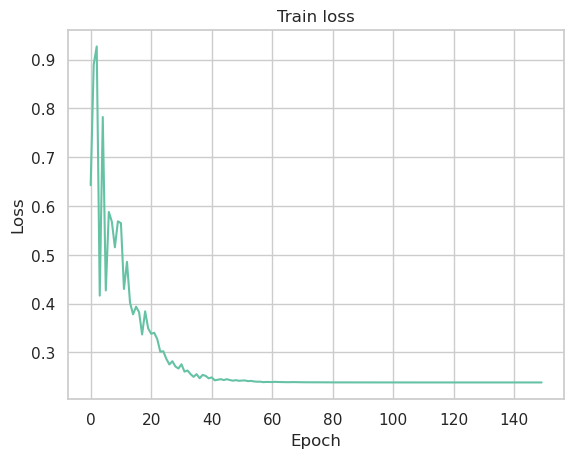

In [17]:
plt.figure()
plt.title('Test loss')
sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Train loss')
plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Training an Encrypted Logistic Regression Model on Encrypted Data

In [18]:
class EncryptedLR:
    
    def __init__(self, torch_lr , is_encrypted=True, approx_sigmoid=True, learning_rate=1e-5, l1=0.005):
        
        self.is_encrypted = is_encrypted
        self.approx_sigmoid = approx_sigmoid
        self.learning_rate = learning_rate
        self.l1 = l1
        
        if is_encrypted:
            self.weight = torch_lr.lr.weight.data.tolist()[0]
            self.bias = torch_lr.lr.bias.data.tolist()
        else:
            self.weight = torch_lr.lr.weight[0].clone().detach()
            self.bias = torch_lr.lr.bias.clone().detach()
        
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = self.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
#        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        
        if self.learning_rate is None:
            self.weight -= self._delta_w * (1 / self._count) + self.weight * self.l1
            self.bias -= self._delta_b * (1 / self._count)
        else:
            self.weight -= self._delta_w * self.learning_rate + self.weight * self.l1
            self.bias -= self._delta_b * self.learning_rate
        
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        

        # store class
    def store_data(self):
        with open("enc_data_class5.pkl", "wb") as f:
            pickle.dump({'enc_data': self}, f)
             
        joblib.dump(self, './enc_data_class5.joblib')
    
    def sigmoid(self, enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        if self.is_encrypted:
            return enc_x.polyval([0.500781, 0.14670403, 0.001198, -0.001006])
        else:
            if self.approx_sigmoid:
                return 0.500781 + (0.14670403 * enc_x) + (0.001198 * enc_x**2) - (0.001006 * enc_x**3)
            else:
                return torch.sigmoid(enc_x)
    
    def bce_loss(self, x_test,  y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b)#.reshape(-1, 1)
#        print(out.shape)
#        print(y_test[:, 0].shape)
        loss = torch.nn.BCELoss()
        loss_value = loss(out, y_test[:, 0])
  
        return loss_value
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        acc = acc_fn(out, y_test)        
        return acc
    
    def plain_f1score(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        f1 = f1_fn(out, y_test)
        return f1
    
    def plain_precision(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)

        pre = pre_fn(out, y_test)
        return pre
    
    def plain_auroc(self, X_test, y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)

        out = torch.sigmoid(X_test.matmul(w) + b)
        
        auc = auroc_fn(out, y_test) 
        return auc   
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

## encryption params

In [19]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_train = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_train.global_scale = 2 ** 21
ctx_train.generate_galois_keys()

## encrypt data

In [20]:
t_start = time()

def encrypt_data(X, ctx_train):
    enc_X = []

    for i in tqdm.tqdm(range(len(X)), desc='Encrypt train data'):
        x = X[i]
        x_enc = ts.ckks_vector(ctx_train, x.tolist())
        enc_X.append(x_enc)

    t_end = time()
    
    return enc_X

enc_x_train = encrypt_data(X_train, ctx_train)
enc_x_test = encrypt_data(X_test, ctx_train)
enc_y_train = encrypt_data(y_train, ctx_train)
enc_y_test = encrypt_data(y_test, ctx_train)

Encrypt train data: 100%|██████████| 1821/1821 [00:17<00:00, 102.86it/s]


## Looks at distribution of linear layer output

Distribution on plain data:


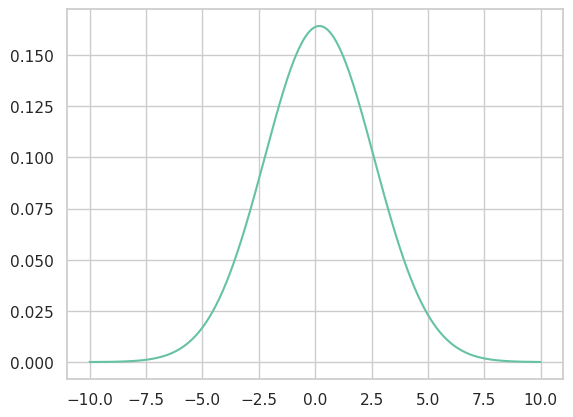

Distribution on encrypted data:


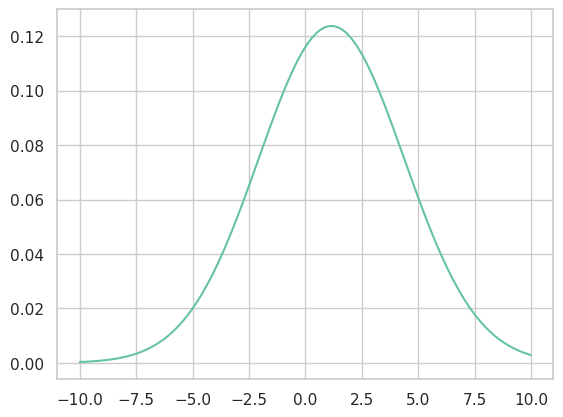

In [38]:
# model instance
set_seed()

epochs = 100
model = LR(n_features)

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
data = model.lr(X_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(model)
eelr.encrypt(ctx_train)
encrypted_out_distribution(eelr, enc_x_train)

# train encrypted model on plain data. Use torch.softmax

In [25]:
def train_enc_model_non_enc_data(learning_rate=1e-6, l1=0.005, epochs=200, approx_sigmoid=False):
    set_seed()

    # a model instance. change to True for encrypted data
    lr = LR(n_features)
    eelr = EncryptedLR(lr, is_encrypted=False, approx_sigmoid=approx_sigmoid, learning_rate=learning_rate, l1=l1)

    #
    # eelr.encrypt(ctx_train)


    times = []
    test_loss_hist = []
    train_loss_hist = []
    train_f1_hist = []
    test_f1_hist = []
    train_pr_hist = []
    test_pr_hist = []
    gradient_w = []
    gradient_b = []

    for epoch in tqdm.tqdm(range(epochs)):

        t_start = time()
        for enc_x, enc_y in zip(X_train, y_train):
            enc_out = eelr.forward(enc_x)
            eelr.backward(enc_x, enc_out, enc_y)

        gradient_w.append(eelr._delta_w.abs().mean())
        gradient_b.append(eelr._delta_b.abs().mean())

        eelr.update_parameters()
        t_end = time()
        times.append(t_end - t_start)
        
#        eelr.decrypt()

        enc_accuracy_test = eelr.plain_accuracy(X_test, y_test)
        enc_precision_test = eelr.plain_precision(X_test, y_test)
        enc_f1score_test = eelr.plain_f1score(X_test, y_test)
        test_f1_hist.append(enc_f1score_test.item())
        
        test_pr_hist.append(enc_precision_test.item())
        
        enc_auc_test = eelr.plain_auroc(X_test, y_test)
        enc_loss_test = eelr.bce_loss(X_test, y_test)
        test_loss_hist.append(enc_loss_test.item())
        #print(f"Test Loss at epoch #{epoch + 1} is {enc_loss_test}|Test Accuracy at epoch #{epoch + 1} is {enc_accuracy_test}|Precision is {enc_precision_test}|F1-score is {enc_f1score_test}|AUC is {enc_auc_test}")

        enc_accuracy_train = eelr.plain_accuracy(X_train, y_train)
        enc_precision_train = eelr.plain_precision(X_train, y_train)
        enc_f1score_train = eelr.plain_f1score(X_train, y_train)
        train_f1_hist.append(enc_f1score_train.item())
        train_pr_hist.append(enc_precision_train.item())
        enc_auc_train = eelr.plain_auroc(X_train, y_train)
        enc_loss_train = eelr.bce_loss(X_train, y_train)
        train_loss_hist.append(enc_loss_train.item())
        
    print('Results')
    print(f'f1-score test set: {enc_f1score_test:.2f}')
    print(f'precision test set: {enc_precision_test:.2f}')

    plt.figure(figsize=(3, 2)) 
    plt.title('Test loss')
    sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Test f1')
    sns.lineplot(np.arange(len(test_f1_hist)), test_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train f1')
    plt.plot(np.arange(len(train_f1_hist)), train_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()
    
    plt.figure(figsize=(3, 2)) 
    plt.title('Test precision')
    sns.lineplot(np.arange(len(test_pr_hist)), test_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train precision')
    plt.plot(np.arange(len(train_pr_hist)), train_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Weight gradient')
    plt.plot(np.arange(len(gradient_w)), gradient_w)
    plt.xlabel('Epoch')
    plt.ylabel('grad')
    plt.show()
    

In [111]:
learning_rate = 1e-2
# learning rate
print(format(learning_rate, 'f'))

0.010000


In [36]:
learning_rate = 1e-5
# learning rate
print(format(learning_rate, 'f'))

0.000010


  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_6058/306009276.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_6058/306009276.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.bias)
/tmp/ipykernel_6058/306009276.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.weight)
/tmp/ipykernel_6058/306009276.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Results
f1-score test set: 0.88
precision test set: 0.86


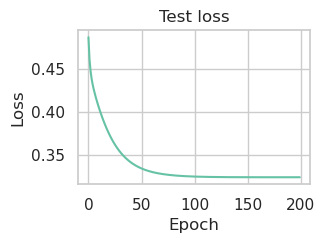

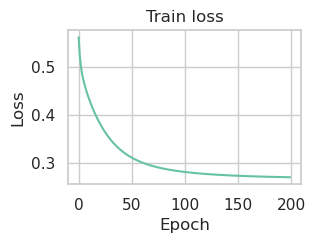

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


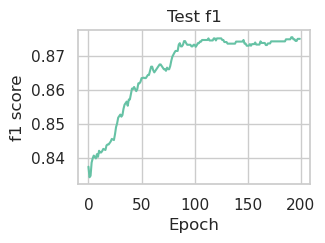

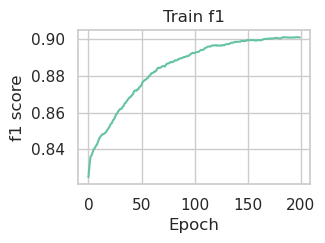

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


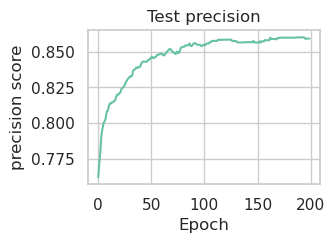

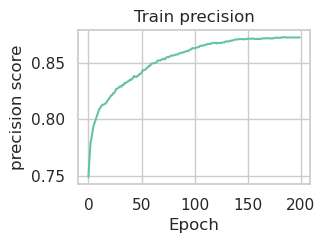

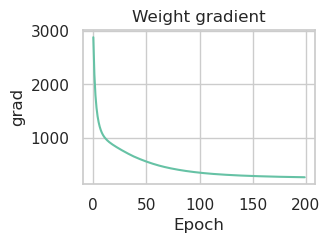

In [30]:
# with 20 features and learning rate 0.00001 and reg 0.005

train_enc_model_non_enc_data(learning_rate=1e-6, l1=0.005, epochs=200)

In [45]:
def train_enc_model_non_enc_data(learning_rate=1e-6, l1=0.005, epochs=120, approx_sigmoid=False):
    set_seed()

    # a model instance. change to True for encrypted data
    lr = LR(n_features)
    eelr = EncryptedLR(lr, is_encrypted=True, approx_sigmoid=approx_sigmoid, learning_rate=learning_rate, l1=l1)

    
    times = []
    test_loss_hist = []
    train_loss_hist = []
    train_f1_hist = []
    test_f1_hist = []
    train_pr_hist = []
    test_pr_hist = []
    gradient_w = []
    gradient_b = []

    for epoch in tqdm.tqdm(range(epochs)):
        eelr.encrypt(ctx_train)

        t_start = time()
        for enc_x, enc_y in zip(enc_x_train, enc_y_train):
            enc_out = eelr.forward(enc_x)
            eelr.backward(enc_x, enc_out, enc_y)

#        gradient_w.append(eelr._delta_w.abs().mean())
#        gradient_b.append(eelr._delta_b.abs().mean())

        eelr.update_parameters()
        t_end = time()
        times.append(t_end - t_start)
        
        eelr.decrypt()

        enc_accuracy_test = eelr.plain_accuracy(X_test, y_test)
        enc_precision_test = eelr.plain_precision(X_test, y_test)
        enc_f1score_test = eelr.plain_f1score(X_test, y_test)
        test_f1_hist.append(enc_f1score_test.item())
        
        test_pr_hist.append(enc_precision_test.item())
        
        enc_auc_test = eelr.plain_auroc(X_test, y_test)
        enc_loss_test = eelr.bce_loss(X_test, y_test)
        test_loss_hist.append(enc_loss_test.item())
        #print(f"Test Loss at epoch #{epoch + 1} is {enc_loss_test}|Test Accuracy at epoch #{epoch + 1} is {enc_accuracy_test}|Precision is {enc_precision_test}|F1-score is {enc_f1score_test}|AUC is {enc_auc_test}")

        enc_accuracy_train = eelr.plain_accuracy(X_train, y_train)
        enc_precision_train = eelr.plain_precision(X_train, y_train)
        enc_f1score_train = eelr.plain_f1score(X_train, y_train)
        train_f1_hist.append(enc_f1score_train.item())
        train_pr_hist.append(enc_precision_train.item())
        enc_auc_train = eelr.plain_auroc(X_train, y_train)
        enc_loss_train = eelr.bce_loss(X_train, y_train)
        train_loss_hist.append(enc_loss_train.item())
        
    print('Results')
    print(f'f1-score test set: {enc_f1score_test:.2f}')
    print(f'precision test set: {enc_precision_test:.2f}')

    plt.figure(figsize=(3, 2)) 
    plt.title('Test loss')
    sns.lineplot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Test f1')
    sns.lineplot(np.arange(len(test_f1_hist)), test_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train f1')
    plt.plot(np.arange(len(train_f1_hist)), train_f1_hist)
    plt.xlabel('Epoch')
    plt.ylabel('f1 score')
    plt.show()
    
    plt.figure(figsize=(3, 2)) 
    plt.title('Test precision')
    sns.lineplot(np.arange(len(test_pr_hist)), test_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Train precision')
    plt.plot(np.arange(len(train_pr_hist)), train_pr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('precision score')
    plt.show()

    plt.figure(figsize=(3, 2)) 
    plt.title('Weight gradient')
    plt.plot(np.arange(len(gradient_w)), gradient_w)
    plt.xlabel('Epoch')
    plt.ylabel('grad')
    plt.show()
    

In [ ]:
train_enc_model_non_enc_data(learning_rate=1e-6, l1=0.005, epochs=200)

 19%|█▉        | 38/200 [9:41:09<41:10:24, 914.97s/it]

In [42]:
torch.manual_seed(15)
random.seed(15)
np.random.seed(15)

    # a model instance
lr = LR(n_features)
eelr = EncryptedLR(lr,  learning_rate=1e-6, l1=0.005)

EPOCHS=100

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    
    enc_accuracy_test = eelr.plain_accuracy(X_test, y_test)
    enc_precision_test = eelr.plain_precision(X_test, y_test)
    enc_f1score_test = eelr.plain_f1score(X_test, y_test)
    enc_auc_test = eelr.plain_auroc(X_test, y_test)
    enc_loss_test = eelr.bce_loss(X_test, y_test)
    print(f"Test Loss at epoch #{epoch + 1} is {enc_loss_test}|Test Accuracy at epoch #{epoch + 1} is {enc_accuracy_test}|Precision is {enc_precision_test}|F1-score is {enc_f1score_test}|AUC is {enc_auc_test}")
    
    enc_accuracy_train = eelr.plain_accuracy(X_train, y_train)
    enc_precision_train = eelr.plain_precision(X_train, y_train)
    enc_f1score_train = eelr.plain_f1score(X_train, y_train)
    enc_auc_train = eelr.plain_auroc(X_train, y_train)
    enc_loss_train = eelr.bce_loss(X_train, y_train)
    print(f"Train Loss at epoch #{epoch + 1} is {enc_loss_train}|Train Accuracy at epoch #{epoch + 1} is {enc_accuracy_train}|Precision is {enc_precision_train}|F1-score is {enc_f1score_train}|AUC is {enc_auc_train}")  

Test Loss at epoch #1 is 4.180527210235596|Test Accuracy at epoch #1 is 0.820977509021759|Precision is 0.8708860874176025|F1-score is 0.8084606528282166|AUC is 0.8694560527801514
Train Loss at epoch #1 is 3.9518473148345947|Train Accuracy at epoch #1 is 0.832141101360321|Precision is 0.8622545003890991|F1-score is 0.8248616456985474|AUC is 0.8867460489273071
Test Loss at epoch #2 is 17.695098876953125|Test Accuracy at epoch #2 is 0.8220757842063904|Precision is 0.8712121248245239|F1-score is 0.8098591566085815|AUC is 0.8230867385864258
Train Loss at epoch #2 is 16.641399383544922|Train Accuracy at epoch #2 is 0.8330044150352478|Precision is 0.8638814091682434|F1-score is 0.8256053328514099|AUC is 0.8336061239242554
Test Loss at epoch #3 is 44.75563049316406|Test Accuracy at epoch #3 is 0.5524436831474304|Precision is 0.5373364090919495|F1-score is 0.6313884854316711|AUC is 0.5520923137664795
Train Loss at epoch #3 is 42.59990310668945|Train Accuracy at epoch #3 is 0.5740010142326355|Pr

KeyboardInterrupt: 

In [41]:
torch.manual_seed(15)
random.seed(15)
np.random.seed(15)

    # a model instance
lr = LR(n_features)
eelr = EncryptedLR(lr,  learning_rate=1e-6, l1=0.005)

EPOCHS=1

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    
    enc_accuracy_test = eelr.plain_accuracy(X_test, y_test)
    enc_precision_test = eelr.plain_precision(X_test, y_test)
    enc_f1score_test = eelr.plain_f1score(X_test, y_test)
    enc_auc_test = eelr.plain_auroc(X_test, y_test)
    enc_loss_test = eelr.bce_loss(X_test, y_test)
    print(f"Test Loss at epoch #{epoch + 1} is {enc_loss_test}|Test Accuracy at epoch #{epoch + 1} is {enc_accuracy_test}|Precision is {enc_precision_test}|F1-score is {enc_f1score_test}|AUC is {enc_auc_test}")
    
    enc_accuracy_train = eelr.plain_accuracy(X_train, y_train)
    enc_precision_train = eelr.plain_precision(X_train, y_train)
    enc_f1score_train = eelr.plain_f1score(X_train, y_train)
    enc_auc_train = eelr.plain_auroc(X_train, y_train)
    enc_loss_train = eelr.bce_loss(X_train, y_train)
    print(f"Train Loss at epoch #{epoch + 1} is {enc_loss_train}|Train Accuracy at epoch #{epoch + 1} is {enc_accuracy_train}|Precision is {enc_precision_train}|F1-score is {enc_f1score_train}|AUC is {enc_auc_train}")  

Test Loss at epoch #1 is 0.43950265645980835|Test Accuracy at epoch #1 is 0.8297638893127441|Precision is 0.8096708059310913|F1-score is 0.8354564905166626|AUC is 0.8908731937408447
Train Loss at epoch #1 is 0.48106157779693604|Train Accuracy at epoch #1 is 0.8307918906211853|Precision is 0.8032867312431335|F1-score is 0.8381317853927612|AUC is 0.8813116550445557
